In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import datetime
import hashlib
import os
import gc
pd.options.display.max_rows = 500
pd.options.display.max_columns = 200

In [2]:
train_transaction = pd.read_csv('./data/train_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('./data/train_identity.csv', index_col='TransactionID')
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
del train_transaction, train_identity
gc.collect()

0

In [3]:
test_transaction = pd.read_csv('./data/test_transaction.csv', index_col='TransactionID')
test_identity = pd.read_csv('./data/test_identity.csv', index_col='TransactionID')
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)
del test_transaction, test_identity
gc.collect()

0

In [4]:
test.columns = test.columns.str.replace('-', '_')

In [1]:
selected_features = ['TransactionDT',
 'TransactionAmt','card1','card2','card3','card5',
 'addr1','addr2',
 'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
 'D1','D2','D3','D4','D5','D6','D7','D8', 'D9', 'D10','D11','D12','D13','D14','D15','V307',
 'ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'R_emaildomain', 
 'dist1','id_30','id_31', 'id_32', 'id_33', 'id_34',
 'DeviceType','DeviceInfo',
  'V314', 'V310', 'V127', 'V78', 'V62', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8']


In [2]:
len(selected_features) # -7

64

In [8]:
train = train[selected_features+['isFraud']]
test = test[selected_features]

In [9]:
train.shape, test.shape

((590540, 65), (506691, 64))

In [10]:
# train = train[selected_features + ['isFraud']]
# test = test[selected_features]

In [11]:
# train = train.fillna(-999)
# test = test.fillna(-999)

In [12]:
train['D9'] = (train['TransactionDT'] % (3600*24) / 3600 // 1 )
test['D9'] = (test['TransactionDT'] % (3600*24) / 3600 // 1 )

In [13]:
train['uid'] = train['card1'].astype(str)+'_'+train['card2'].astype(str)+'_'+train['card3'].astype(str)+'_'+train['card4'].astype(str)
test['uid'] = test['card1'].astype(str)+'_'+test['card2'].astype(str)+'_'+test['card3'].astype(str)+'_'+test['card4'].astype(str)

train['uid2'] = train['uid'].astype(str)+'_'+train['addr1'].astype(str)+'_'+train['addr2'].astype(str)
test['uid2'] = test['uid'].astype(str)+'_'+test['addr1'].astype(str)+'_'+test['addr2'].astype(str)

i_cols = ['card1','card2','card3','card5','uid','uid2']

for col in i_cols:
    for agg_type in ['mean', 'std', 'nunique']:
        new_col_name = col+'_TransactionAmt_'+agg_type
        temp = pd.concat([train[[col, 'TransactionAmt']], test[[col,'TransactionAmt']]])

        temp = temp.groupby([col])['TransactionAmt'].agg([agg_type]).reset_index().rename(
                                                columns={agg_type: new_col_name})

        temp.index = list(temp[col])

        temp = temp[new_col_name].to_dict()   

        train[new_col_name] = train[col].map(temp)
        test[new_col_name]  = test[col].map(temp)

In [14]:
train['bank_type'] = train['card3'].astype(str)+'_'+train['card5'].astype(str)
test['bank_type']  = test['card3'].astype(str)+'_'+test['card5'].astype(str)

train['address_match'] = train['bank_type'].astype(str)+'_'+train['addr2'].astype(str)
test['address_match']  = test['bank_type'].astype(str)+'_'+test['addr2'].astype(str)
print("1. bank_type 및 address_match 생성")
print(train[['bank_type', 'address_match']].head())
print(test[['bank_type', 'address_match']].head())

1. bank_type 및 address_match 생성
                 bank_type     address_match
TransactionID                               
2987000        150.0_142.0  150.0_142.0_87.0
2987001        150.0_102.0  150.0_102.0_87.0
2987002        150.0_166.0  150.0_166.0_87.0
2987003        150.0_117.0  150.0_117.0_87.0
2987004        150.0_102.0  150.0_102.0_87.0
                 bank_type     address_match
TransactionID                               
3663549        150.0_226.0  150.0_226.0_87.0
3663550        150.0_226.0  150.0_226.0_87.0
3663551        150.0_226.0  150.0_226.0_87.0
3663552        150.0_166.0  150.0_166.0_87.0
3663553        150.0_117.0  150.0_117.0_87.0


In [15]:
for col in ['address_match','bank_type']:
    temp = pd.concat([train[[col]], test[[col]]])
    temp[col] = np.where(temp[col].str.contains('nan'), np.nan, temp[col])
    temp = temp.dropna()
    fq_encode = temp[col].value_counts().to_dict()   
    train[col] = train[col].map(fq_encode)
    test[col]  = test[col].map(fq_encode)
print("\n2. 빈도 인코딩 후")
print(train[['bank_type', 'address_match']].head())
print(test[['bank_type', 'address_match']].head())


2. 빈도 인코딩 후
               bank_type  address_match
TransactionID                          
2987000            309.0          309.0
2987001          44082.0        43735.0
2987002         101292.0       101179.0
2987003          47059.0        46950.0
2987004          44082.0        43735.0
               bank_type  address_match
TransactionID                          
3663549         531549.0       526981.0
3663550         531549.0       526981.0
3663551         531549.0       526981.0
3663552         101292.0       101179.0
3663553          47059.0        46950.0


In [16]:
train['address_match'] = train['address_match']/train['bank_type'] 
test['address_match']  = test['address_match']/test['bank_type']
print("\n3. 상대적 비율 계산 후")
print(train[['bank_type', 'address_match']].head())
print(test[['bank_type', 'address_match']].head())


3. 상대적 비율 계산 후
               bank_type  address_match
TransactionID                          
2987000            309.0       1.000000
2987001          44082.0       0.992128
2987002         101292.0       0.998884
2987003          47059.0       0.997684
2987004          44082.0       0.992128
               bank_type  address_match
TransactionID                          
3663549         531549.0       0.991406
3663550         531549.0       0.991406
3663551         531549.0       0.991406
3663552         101292.0       0.998884
3663553          47059.0       0.997684


In [17]:
start_date = datetime.datetime.strptime('2017.11.30', '%Y.%m.%d')
train['timeblock'] = train['TransactionDT'].apply(lambda x: datetime.timedelta(seconds=x) + start_date)
test['timeblock'] = test['TransactionDT'].apply(lambda x: datetime.timedelta(seconds=x) + start_date)

tb = train['timeblock']
print(train.timeblock.head())
train.drop('timeblock', axis=1, inplace=True)
train.insert(0, 'timeblock', tb)

tb = test['timeblock']
print(test.timeblock.head())
test.drop('timeblock', axis=1, inplace=True)
test.insert(0, 'timeblock', tb)

TransactionID
2987000   2017-12-01 00:00:00
2987001   2017-12-01 00:00:01
2987002   2017-12-01 00:01:09
2987003   2017-12-01 00:01:39
2987004   2017-12-01 00:01:46
Name: timeblock, dtype: datetime64[ns]
TransactionID
3663549   2018-07-01 00:00:24
3663550   2018-07-01 00:01:03
3663551   2018-07-01 00:01:50
3663552   2018-07-01 00:01:50
3663553   2018-07-01 00:01:57
Name: timeblock, dtype: datetime64[ns]


In [18]:
def account_start_date(val):
    if np.isnan(val):
        return np.NaN
    else:
        days = int(str(val).split('.')[0])
        return pd.Timedelta(str(days) + ' days')

In [19]:
for i in ['D1', 'D2', 'D4', 'D8', 'D10', 'D15']:
    train['account_start_day'] = train[i].apply(account_start_date)
    test['account_start_day'] = test[i].apply(account_start_date)

    # account_make_date 컴퓨터가 인식할 수 있도록 수치형으로 바꿔 줌. 
    train['account_make_date'] = (train['timeblock'] - train['account_start_day']).dt.date
    test['account_make_date'] = (test['timeblock'] - test['account_start_day']).dt.date

    train['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(train['account_make_date']).dt.year) + (100 * pd.to_datetime(train['account_make_date']).dt.month) + (1 * pd.to_datetime(train['account_make_date']).dt.day)
    test['account_make_date_{}'.format(i)] = (10000 * pd.to_datetime(test['account_make_date']).dt.year) + (100 * pd.to_datetime(test['account_make_date']).dt.month) + (1 * pd.to_datetime(test['account_make_date']).dt.day)

In [20]:
del train['account_make_date']; del test['account_make_date']
del train['account_start_day']; del test['account_start_day']

In [21]:
train['date'] = pd.to_datetime(train['timeblock']).dt.date
test['date'] = pd.to_datetime(test['timeblock']).dt.date

train['year'] = train['timeblock'].dt.year
train['month'] = train['timeblock'].dt.month
train['day'] = train['timeblock'].dt.day
train['dayofweek'] = train['timeblock'].dt.dayofweek
train['hour'] = train['timeblock'].dt.hour
# train['minute'] = train['timeblock'].dt.minute
# train['second'] = train['timeblock'].dt.second

test['year'] = test['timeblock'].dt.year
test['month'] = test['timeblock'].dt.month
test['day'] = test['timeblock'].dt.day
test['dayofweek'] = test['timeblock'].dt.dayofweek
test['hour'] = test['timeblock'].dt.hour
# test['minute'] = test['timeblock'].dt.minute
# test['second'] = test['timeblock'].dt.second

In [22]:
# 이전 거래와의 시간 차이 계산
train['prev_transaction_diff'] = train.groupby('uid')['TransactionDT'].diff().fillna(-1)
test['prev_transaction_diff'] = test.groupby('uid')['TransactionDT'].diff().fillna(-1)

In [23]:
def card_info_hash(x):
    s = (str(x['card1'])+
         str(x['card2'])+
         str(x['card3'])+
         str(x['card4'])+
         str(x['card5'])+
         str(x['card6']))
    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

def device_hash(x):
    s =  str(x['id_30'])+str(x['id_31'])+str(x['id_32'])+str(x['id_33'])+str( x['DeviceType'])+ str(x['DeviceInfo'])
    h = hashlib.sha256(s.encode('utf-8')).hexdigest()[0:15]
    return h

train['card_hash'] = train.apply(lambda x: card_info_hash(x), axis=1   )
train['device_hash'] = train.apply(lambda x: device_hash(x), axis=1   )

test['card_hash'] = test.apply(lambda x: card_info_hash(x), axis=1   )
test['device_hash'] = test.apply(lambda x: device_hash(x), axis=1   )

In [24]:
train['V307_diff'] = train['V307'].diff().shift(-1)
train['difference'] = train['V307_diff'] - train['TransactionAmt']

test['V307_diff'] = test['V307'].diff().shift(-1)
test['difference'] = test['V307_diff'] - test['TransactionAmt']

In [25]:
total = pd.concat([train,test],axis=0,sort=False)

train['uid2_next_click'] = train['TransactionDT'] - train.groupby(['uid2'])['TransactionDT'].shift(-1)
test['uid2_next_click'] = test['TransactionDT'] - test.groupby(['uid2'])['TransactionDT'].shift(-1)

train = train.merge(total.groupby(['uid','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid_D1_productCD_Amt_mean','std':'uid_D1_productCD_Amt_std'}), how='left', on = ['uid','account_make_date_D1','ProductCD'])
test = test.merge(total.groupby(['uid','account_make_date_D1','ProductCD'])['TransactionAmt'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid_D1_productCD_Amt_mean','std':'uid_D1_productCD_Amt_std'}), how='left', on = ['uid','account_make_date_D1','ProductCD'])
train = train.merge(total.groupby(['uid2','ProductCD'])['dayofweek'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), how='left', on = ['uid2','ProductCD'])
test = test.merge(total.groupby(['uid2','ProductCD'])['dayofweek'].agg({'mean','std'}).reset_index().rename(columns={'mean':'uid2_dayofweek_mean','std':'uid2_dayofweek_std'}), how='left', on = ['uid2','ProductCD'])

In [26]:
del train['uid']; del train['uid2']; del train['bank_type']
del test['uid']; del test['uid2']; del test['bank_type']

In [27]:
# M1부터 M9까지 컬럼 목록
m_columns = [f'M{i}' for i in range(1, 9)]

# M4를 제외한 나머지 컬럼들에 대해 T/F를 1/0으로 변환
mapping = {'T': 1, 'F': 0}
for col in m_columns:
    if col != 'M4':
        # train[col] = train[col].map(mapping).fillna(-999)
        # test[col] = test[col].map(mapping).fillna(-999)
        train[col] = train[col].map(mapping)
        test[col] = test[col].map(mapping)

# M4에 대해 라벨 인코딩 수행
label_encoder = LabelEncoder()
train['M4'] = label_encoder.fit_transform(train['M4'].astype(str))
test['M4'] = label_encoder.transform(test['M4'].astype(str))

In [28]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and not np.issubdtype(col_type, np.datetime64):
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [29]:
# 적용
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 468.57 MB
Memory usage after optimization is: 182.47 MB
Decreased by 61.1%
Memory usage of dataframe is 398.17 MB
Memory usage after optimization is: 157.05 MB
Decreased by 60.6%


In [30]:
test = test.drop(['V307','id_30','id_31','id_32','id_33','DeviceType','DeviceInfo'], axis=1)
train = train.drop(['V307','id_30','id_31','id_32','id_33','DeviceType','DeviceInfo'], axis=1)

In [31]:
# 범주형 열을 숫자형으로 변환
def encode_categorical_columns(df):
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    return df

In [33]:
# train 데이터 인코딩
train = encode_categorical_columns(train)

# test 데이터 인코딩
test_encoded = encode_categorical_columns(test)

In [34]:
y = train['isFraud']
X = train.drop('isFraud', axis=1)
X.shape, y.shape, test_encoded.shape

((590540, 99), (590540,), (506691, 99))

In [35]:
# DateTime64 타입의 열을 숫자 형식으로 변환하는 함수
def convert_datetime_columns(df):
    for col in df.columns:
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = df[col].astype('int64') // 10**9  # 초 단위로 변환
    return df

# Assuming X is your feature DataFrame
X = convert_datetime_columns(X)
test_encoded = convert_datetime_columns(test_encoded)

In [36]:
X['DT_M'] = (X['year']-2017)*12 + X['month'] 
test_encoded['DT_M'] = (test_encoded['year']-2017)*12 + test_encoded['month']

In [37]:
X.shape, y.shape, test_encoded.shape

((590540, 100), (590540,), (506691, 100))

In [38]:
params = {
    'objective': 'binary',
    "metric": 'auc',
    'num_leaves': 491,
    'feature_fraction': 0.3797454081646243,
    'bagging_fraction': 0.4181193142567742,
    'min_data_in_leaf': 106,
    'max_depth': -1,
    'learning_rate': 0.006883242363721497,
    'reg_alpha': 0.3899927210061127,
    'reg_lambda': 0.6485237330340494,
    'random_state': 2024
         }



In [73]:
X['DT_M']

0         12
1         12
2         12
3         12
4         12
          ..
590535    17
590536    17
590537    17
590538    17
590539    17
Name: DT_M, Length: 590540, dtype: int16

In [81]:
from time import time
import datetime 

from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, GroupKFold

NFOLD = 4
folds =  GroupKFold(n_splits=NFOLD)
split_groups = X['DT_M']

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
oofs = np.zeros(len(X))
preds = np.zeros(len(test_encoded))

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y, groups = split_groups)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

    callbacks = [lgb.early_stopping(stopping_rounds=100), 
                 lgb.log_evaluation(period=500)]
    clf = lgb.train(params, trn_data, 
                    num_boost_round = 10000, 
                    valid_sets = [trn_data, val_data],
                    callbacks=callbacks)
    
    oofs[test_idx] = clf.predict(X.iloc[test_idx])
    preds += clf.predict(test)/NFOLD
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print("Total Validation: ", roc_auc_score(y, oofs))
print('-' * 30)

Training on fold 1
[LightGBM] [Info] Number of positive: 17113, number of negative: 436106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16391
[LightGBM] [Info] Number of data points in the train set: 453219, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.037759 -> initscore=-3.238047
[LightGBM] [Info] Start training from score -3.238047
Training until validation scores don't improve for 100 rounds
[500]	training's auc: 0.989946	valid_1's auc: 0.894298
[1000]	training's auc: 0.998922	valid_1's auc: 0.90336
[1500]	training's auc: 0.999909	valid_1's auc: 0.905877
[2000]	training's auc: 0.999995	valid_1's auc: 0.907827
[2500]	training's auc: 1	valid_1's auc: 0.909087
[3000]	training's auc: 1	valid_1's auc: 0.909531
[3500]	training's auc: 1	valid_1's auc

In [ ]:
    params = {
    'objective': 'binary',
    "metric": 'auc',
    'num_leaves': 491,
    'min_child_weight' : 0.0354423456321421,
    'feature_fraction': 0.3797454081646243,
    'bagging_fraction': 0.4181193142567742,
    'min_data_in_leaf': 106,
    'max_depth': -1,
    'learning_rate': 0.006883242363721497,
    'reg_alpha': 0.3899927210061127,
    'reg_lambda': 0.6485237330340494,
    'random_state': 2024
         }

Text(0.5, 1.0, '25 TOP feature importance over 4 folds average')

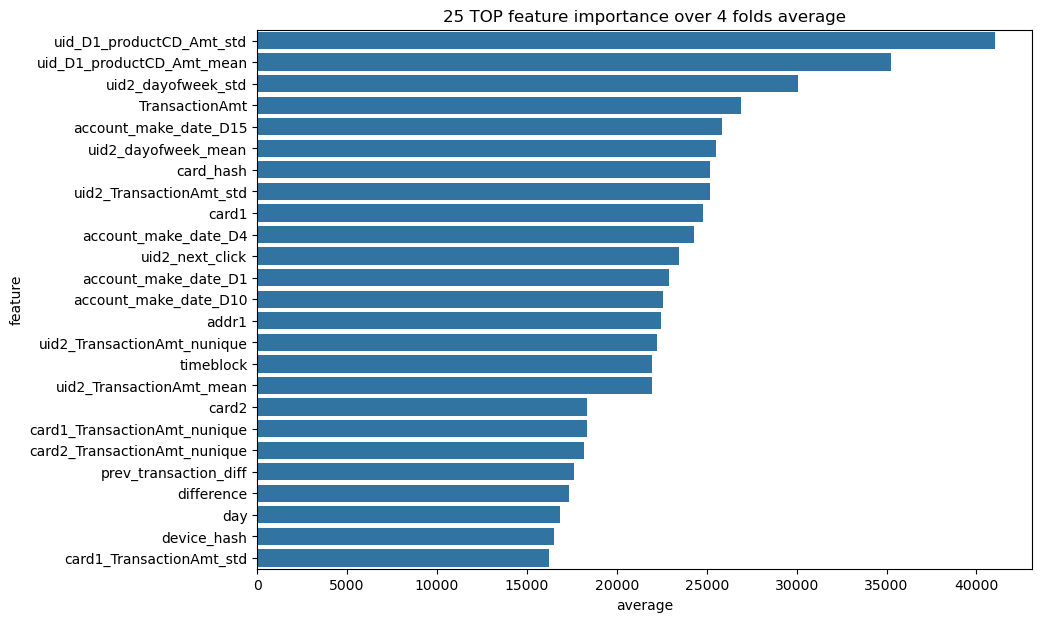

In [103]:
import seaborn as sns
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(10, 7))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(25), x='average', y='feature');
plt.title('25 TOP feature importance over {} folds average'.format(folds.n_splits))

In [83]:
result = pd.read_csv('./data/sample_submission.csv')
result['isFraud'] = preds
result.to_csv('final_result.csv',index=False)
print(result)

        TransactionID   isFraud
0             3663549  0.000727
1             3663550  0.001886
2             3663551  0.002130
3             3663552  0.001302
4             3663553  0.002818
...               ...       ...
506686        4170235  0.005382
506687        4170236  0.003911
506688        4170237  0.002982
506689        4170238  0.002953
506690        4170239  0.003782

[506691 rows x 2 columns]


In [79]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
def objective_lgbm(trial):
    param_suggest = {
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': trial.suggest_int('num_leaves', 200, 600),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 0.8),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 100, 110),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'random_state': 2024
    }

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    
    model = lgb.train(param_suggest, train_data, num_boost_round=2500, 
                      valid_sets=[train_data, valid_data], 
                      early_stopping_rounds=100, 
                      verbose_eval=False)
    
    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    auc = roc_auc_score(y_valid, y_pred)
    
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective_lgbm, n_trials=100)

best_params = study.best_params
print('Best Parameters:', best_params)

In [ ]:
def print_columns(df):
    print("Columns in the DataFrame:")
    print(", ".join(df.columns))

print_columns(test_encoded)
print_columns(train)

Columns in the DataFrame:
timeblock, TransactionDT, TransactionAmt, card1, card2, card3, card5, addr1, addr2, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, D1, D2, D3, D4, D5, D6, D7, D8, D9, D10, D11, D12, D13, D14, D15, ProductCD, card4, card6, P_emaildomain, R_emaildomain, dist1, id_34, V314, V310, V127, V78, V62, M1, M2, M3, M4, M5, M6, M7, M8, card1_TransactionAmt_mean, card1_TransactionAmt_std, card1_TransactionAmt_nunique, card2_TransactionAmt_mean, card2_TransactionAmt_std, card2_TransactionAmt_nunique, card3_TransactionAmt_mean, card3_TransactionAmt_std, card3_TransactionAmt_nunique, card5_TransactionAmt_mean, card5_TransactionAmt_std, card5_TransactionAmt_nunique, uid_TransactionAmt_mean, uid_TransactionAmt_std, uid_TransactionAmt_nunique, uid2_TransactionAmt_mean, uid2_TransactionAmt_std, uid2_TransactionAmt_nunique, address_match, account_make_date_D1, account_make_date_D2, account_make_date_D4, account_make_date_D8, account_make_date_D10, account_make_date_D

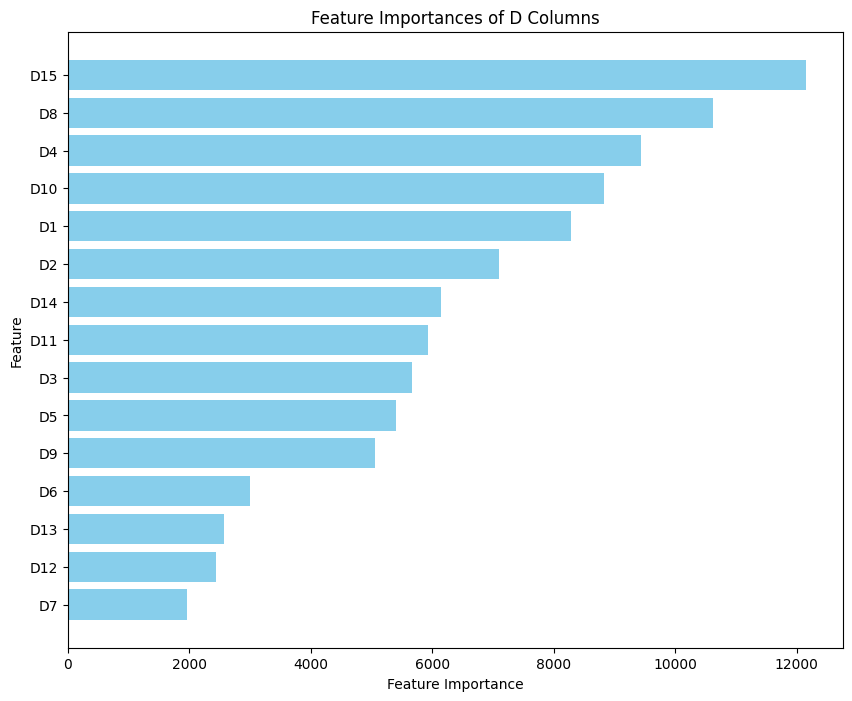

In [ ]:
# 피처 중요도 추출
importance = clf.feature_importance()
feature_names = X_tr.columns

# 피처 중요도를 데이터프레임으로 변환
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
})

# 'D'로 시작하는 피처만 필터링
d_features = importance_df[importance_df['feature'].str.startswith('D')]

# 중요도 순으로 정렬
d_features = d_features.sort_values(by='importance', ascending=False)

# 피처 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(d_features['feature'], d_features['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances of D Columns')
plt.gca().invert_yaxis()  # 가장 중요한 피처가 위에 오도록 y축을 반전
plt.show()